In [1]:
import xarray as xr
import s3fs
import matplotlib.pyplot as plt
import pandas as pd
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs
import numpy as np

s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", client_kwargs=dict(endpoint_url="https://rgw.met.no"))


## DMS Data

In [9]:
s3.ls('escience2022/Antoine/Satellite_Arctic_DMS')

['escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2003_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2004_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2005_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2006_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2007_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2008_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2009_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2010_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2011_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2012_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2013_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2014_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2015_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2016_8D_28km.nc',
 'esci

## Dask with gateway

In [3]:
from dask.distributed import Client
from dask_gateway import Gateway
gateway = Gateway()

In [4]:
cluster = gateway.new_cluster(worker_memory=2, worker_cores=1)
cluster.scale(8)
client = Client(cluster) # create a dask Gateway cluster
cluster

In [5]:
if cluster:
    client = Client(cluster) # create a dask Gateway cluster
else:
    client = Client()   # create a local dask cluster on the machine.
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /jupyterhub/services/dask-gateway/clusters/daskhub.d9fb6d6b87974c60afe8b37b1053b0d8/status,


In [4]:
#closing open 
# clusters=gateway.list_clusters()
# print(clusters )
# for cluster in clusters :
#     cluster= gateway.connect(cluster.name)
#     print(cluster)
#     client = Client(cluster)
#     client.close()
#     cluster.shutdown()

In [6]:
# To close at end of session
client.close()

In [7]:
cluster.shutdown()

## Open files

In [2]:
#### single file
file = 's3://escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2010_8D_28km.nc'
ds = xr.open_dataset(s3.open(file))

### multiple files
# s3files = 's3://escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A*_8D_28km.nc'
# remote_files = s3.glob(s3files)
# fileset = [s3.open(file) for file in remote_files]
# ds = xr.open_mfdataset(fileset, combine='by_coords')

ds

<xarray.Dataset>
Dimensions:      (pixel: 96668, year: 1, period: 46)
Coordinates:
  * year         (year) float64 2.01e+03
Dimensions without coordinates: pixel, period
Data variables:
    longitude    (pixel) float64 ...
    latitude     (pixel) float64 ...
    startjulday  (period) float64 ...
    endjulday    (period) float64 ...
    dms          (period, year, pixel) float64 ...

In [ ]:
# remove dependence of lat and long on year
ds['latitude'] = ds.latitude.isel(year=0)
ds['longitude'] = ds.longitude.isel(year=0)

In [4]:
# sinusoidal projection transformation
def sinProj(lon,lat):
    lon0=0
    x = (lon- lon0)*np.cos(lat)
    y = lat
    return x,y

# inverse of sin proj
def invSinProj(x,y):
    lon0=0
    lat = y
    lon = x/np.cos(lat) - lon0
    return lon, lat
    
# ds['x'],ds['y'] = sinProj(ds['longitude'],ds['latitude'])
ds['x'],ds['y'] = invSinProj(ds['longitude'],ds['latitude'])
ds

<xarray.Dataset>
Dimensions:      (pixel: 96668, year: 1, period: 46)
Coordinates:
  * year         (year) float64 2.01e+03
Dimensions without coordinates: pixel, period
Data variables:
    longitude    (pixel) float64 -179.8 -179.5 -179.1 ... -120.0 0.0 120.0
    latitude     (pixel) float64 45.12 45.12 45.12 45.12 ... 89.88 89.88 89.88
    startjulday  (period) float64 1.0 9.0 17.0 25.0 ... 337.0 345.0 353.0 361.0
    endjulday    (period) float64 8.0 16.0 24.0 32.0 ... 344.0 352.0 360.0 365.0
    dms          (period, year, pixel) float64 ...
    x            (pixel) float64 -433.2 -432.3 -431.5 ... 360.2 -0.0 -360.2
    y            (pixel) float64 45.12 45.12 45.12 45.12 ... 89.88 89.88 89.88

In [5]:
xy = pd.MultiIndex.from_arrays([ds.x.values, ds.y.values],names=["lat", "lon"])
xy.sortlevel(level=1)


(MultiIndex([(-433.16494210547614, 45.125),
             (-432.31143126401855, 45.125),
             ( -431.4578818810751, 45.125),
             ( -430.6043710396175, 45.125),
             (-429.75086019815996, 45.125),
             (-428.89731081521643, 45.125),
             ( -428.0437999737589, 45.125),
             (-427.19025059081537, 45.125),
             (-426.33673974935783, 45.125),
             ( -425.4832264990573, 45.125),
             ...
             ( -893.9596663613055, 89.625),
             (-446.97983318065275, 89.625),
             (               -0.0, 89.625),
             ( 446.97983318065275, 89.625),
             (  893.9596663613055, 89.625),
             ( 1340.9394995419582, 89.625),
             (  1787.919332722611, 89.625),
             ( -360.2318441464199, 89.875),
             (               -0.0, 89.875),
             (  360.2318441464199, 89.875)],
            names=['lat', 'lon'], length=96668),
 array([    0,     1,     2, ..., 96667, 96666, 96665

In [ ]:
#### change coordinate from pixel (1d) to lat lon (2d)

### DOES NOT WORK : grid is not structured and rounding longitude will lead to superposing pixels tw0 pixel on same point
# lalo = pd.MultiIndex.from_arrays([ds.latitude.values, ds.longitude.values.round()],names=["lat", "lon"])

lalo = pd.MultiIndex.from_arrays([ds.latitude.values, ds.longitude.values],names=["lat", "lon"])
lalo.sortlevel(level=1)
##checking for duplicates
# m = np.zeros_like(lalo, dtype=bool)
# m[np.unique(lalo, return_index=True)[1]] = True
# lalo[~m]

In [5]:
# 
ds=ds.assign_coords({ "pixel": lalo }).unstack("pixel")
ds#.sel(lat=45.125)

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 91637, year: 1, period: 46)
Coordinates:
  * lat          (lat) float64 45.12 45.38 45.62 45.88 ... 89.38 89.62 89.88
  * lon          (lon) float64 -179.8 -179.8 -179.8 -179.8 ... 179.8 179.8 179.8
  * year         (year) float64 2.01e+03
Dimensions without coordinates: period
Data variables:
    longitude    (lat, lon) float64 -179.8 nan nan nan nan ... nan nan nan nan
    latitude     (lat, lon) float64 45.12 nan nan nan nan ... nan nan nan nan
    startjulday  (period) float64 1.0 9.0 17.0 25.0 ... 337.0 345.0 353.0 361.0
    endjulday    (period) float64 8.0 16.0 24.0 32.0 ... 344.0 352.0 360.0 365.0
    dms          (period, year, lat, lon) float64 0.5127 nan nan ... nan nan nan

In [10]:
 np.count_nonzero(~np.isnan(ds.dms.values))

1131007

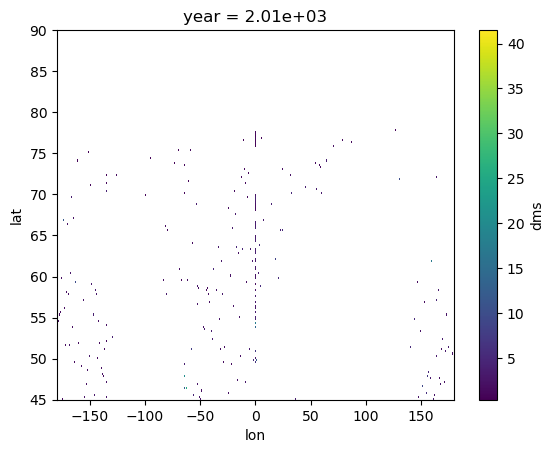

In [5]:
ds.dms.isel(period=30,year=0).plot()

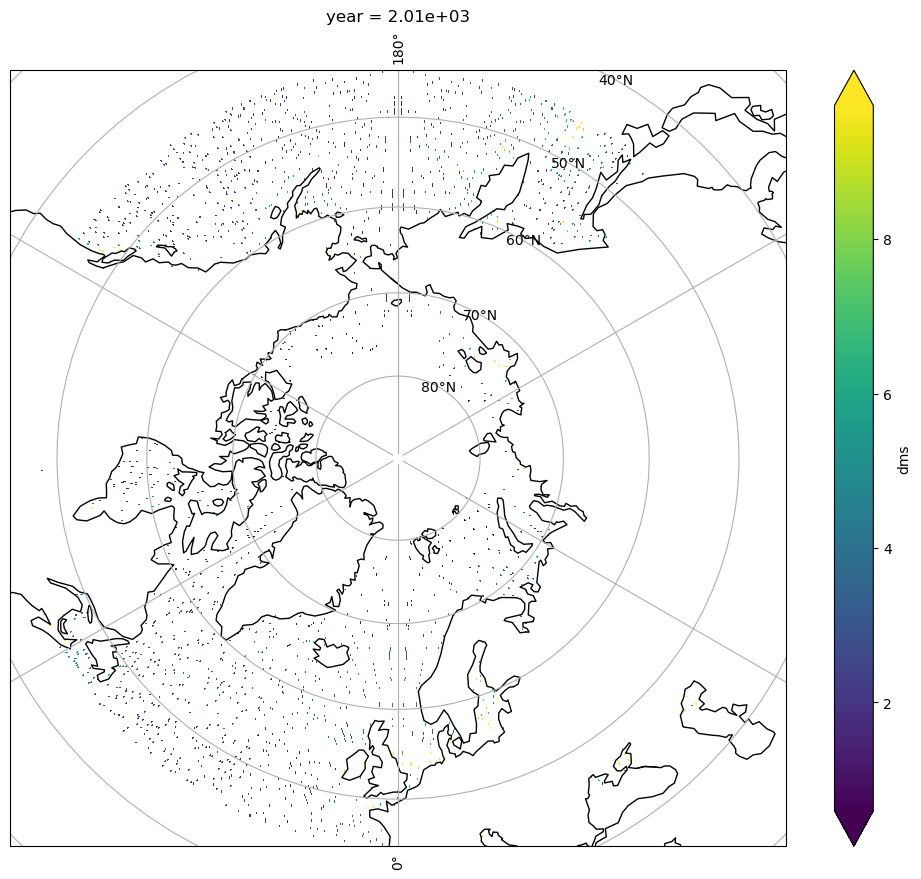

In [4]:
fig, ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':ccrs.NorthPolarStereo()})
ds.dms.isel(period=30,year=0).plot.pcolormesh(
    ax = ax,
    cbar_kwargs={ 'orientation':'vertical', 'shrink':.8},
    transform=ccrs.PlateCarree(),
    robust=True
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax.gridlines(draw_labels=True)
ax.coastlines()
fig.tight_layout()
